In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nescient.utils import getprotobynumber
plt.style.use('default')

from nescient.elasticclient import *

normal_start_time = "2021-03-14T14:11:53"
normal_end_time = "2021-03-14T14:17:02"
dos_start_time = "2021-03-14T14:19:53"
dos_end_time = "2021-03-14T14:24:05"
spoofed_dos_start_time = "2021-03-14T14:29:04"
spoofed_dos_end_time = "2021-03-14T14:33:11"

normal_data_object_array = get_netflow_resampled(start_time=normal_start_time, end_time=normal_end_time)
dos_data_object_array = get_netflow_resampled(start_time=dos_start_time, end_time=dos_end_time)
spoofed_dos_data_object_array = get_netflow_resampled(start_time=spoofed_dos_start_time, end_time=spoofed_dos_end_time)

# prepare elastic data

data_to_be_used = normal_data_object_array # switch this variable for other case

mapped = map(lambda bucket: {
    "key": bucket['key'],
    "packets": bucket['packets']['value'],
    "USIP": bucket['USIP']['value'],
    "UDIP": bucket['UDIP']['value'],
    "UPR": bucket['UPR']['value']
}, data_to_be_used)

A1_all = []
A2_all = []
A3_all = []
A4_all = []

A1_for_display = []
A2_for_display = []
A3_for_display = []
A4_for_display = []

for bucket in data_to_be_used:
    A1_for_display.append(bucket['packets']['value'])
    A2_for_display.append(bucket['USIP']['value'])
    A3_for_display.append(0 if bucket['USIP']['value'] == 0 or bucket['UDIP']['value'] == 0 else bucket['USIP']['value'] / bucket['UDIP']['value'])
    A4_for_display.append(0 if bucket['USIP']['value'] == 0 or bucket['UPR']['value'] == 0 else bucket['USIP']['value'] / bucket['UPR']['value'])

for bucket in data_to_be_used:
    A1_all.append([
        bucket['key'],
        bucket['packets']['value']
    ])
    A2_all.append([
        bucket['key'],
        bucket['USIP']['value']
    ])
    A3_all.append([
        bucket['key'],
        0 if bucket['USIP']['value'] == 0 or bucket['UDIP']['value'] == 0 else bucket['USIP']['value'] / bucket['UDIP']['value']
    ])
    A4_all.append([
        bucket['key'],
        0 if bucket['USIP']['value'] == 0 or bucket['UPR']['value'] == 0 else bucket['USIP']['value'] / bucket['UPR']['value']
    ])


A_all = (
    pd.DataFrame(A1_all),
    pd.DataFrame(A2_all),
    pd.DataFrame(A3_all),
    pd.DataFrame(A4_all)
)


In [7]:

Threshold_all = []
N_all = []
beta_all = []

j_to_end = range(len(A1_all))

for A in A_all:
    # Init values
    K = 1
    beta = 1.5
    j = 0
    T = 3
    current_threshold_array = list()
    current_N_array = list()
    current_beta_array = list()

    A_list = A.iloc[:, 1].to_list()
    safe_A_list = [*A_list, *([0] * K * T)]

    current_moving_A = A.iloc[j: j+K, 1].to_list()
    current_moving_mean = np.mean(current_moving_A)
    current_moving_variance = np.std(current_moving_A)
    current_threshold = (current_moving_mean + current_moving_variance) * beta

    current_threshold_array.append([j, current_threshold])
    current_beta_array.append([j, beta])

    # while j <= K*T-1 and j < len(A1_all.iloc[:, 0].to_list()):
    while j < len(A1_all):
        if j < 0 and j % K*T == 0:
            beta = 1.5
            current_moving_A = safe_A_list[j: j+K]
            current_moving_mean = np.mean(current_moving_A)
            current_moving_variance = np.std(current_moving_A)
            current_threshold = (current_moving_mean + current_moving_variance) * beta

            current_threshold_array.append([j, current_threshold])
            current_beta_array.append([j, beta])
            if safe_A_list[j:j+1][0] > current_threshold:
                current_N_array.append([j, True])
            else:
                current_N_array.append([j, False])
        else:
            if safe_A_list[j:j+1][0] > current_threshold:
                current_N_array.append([j, True])
            else:
                current_N_array.append([j, False])
            j = j + 1
            current_j = j
            previous_j = j - 1
            previous_moving_mean = np.mean(safe_A_list[previous_j: previous_j+K])
            current_moving_mean = np.mean(safe_A_list[current_j: current_j+K])
            if current_moving_mean > 2 * previous_moving_mean:
                beta = beta + 0.5
                current_threshold = (current_moving_mean + np.std(safe_A_list[current_j: current_j+K])) / beta
            else:
                beta = beta - 0.5
                if beta < 1.0:
                    beta = 1
                current_threshold = (current_moving_mean + np.std(safe_A_list[current_j: current_j+K])) * beta
            current_threshold_array.append([current_j, current_threshold])
            current_beta_array.append([j, beta])

    Threshold_all.append(current_threshold_array)
    N_all.append(current_N_array)
    beta_all.append(current_beta_array)


print("again")
print("here")

again
here


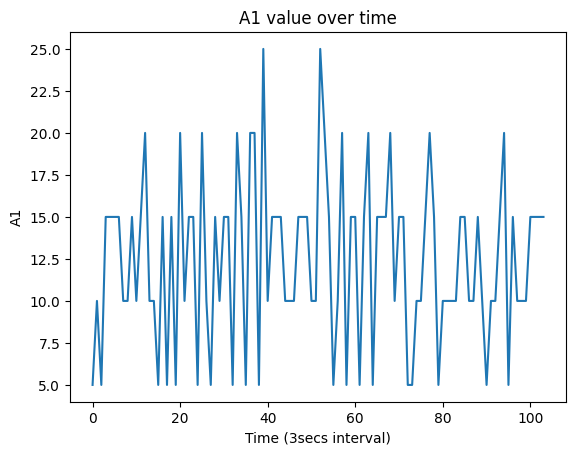

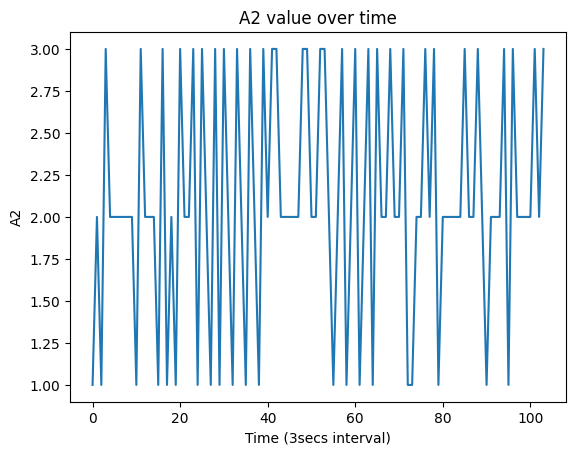

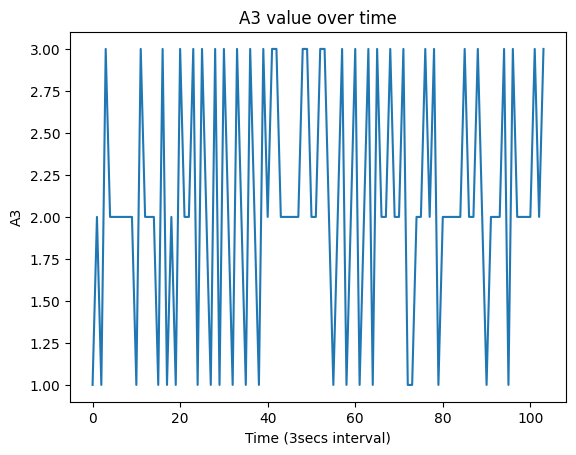

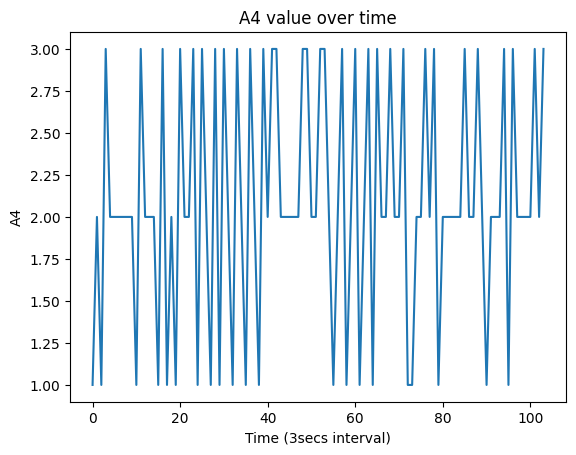

In [8]:
plt.plot(A1_for_display)
#plt.plot(A1_all.iloc[:, 0].to_list())
plt.title("A1 value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("A1")
plt.show()

plt.plot(A2_for_display)
#plt.plot(A2_all.iloc[:, 0].to_list())
plt.title("A2 value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("A2")
plt.show()

plt.plot(A3_for_display)
#plt.plot(A3_all.iloc[:, 0].to_list())
plt.title("A3 value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("A3")
plt.show()

plt.plot(A4_for_display)
#plt.plot(A4_all.iloc[:, 0].to_list())
plt.title("A4 value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("A4")
plt.show()

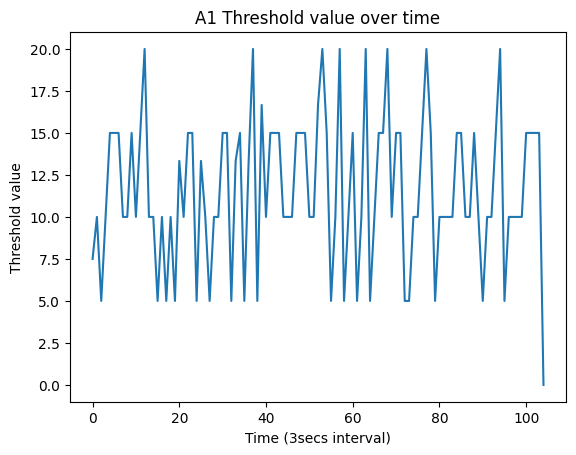

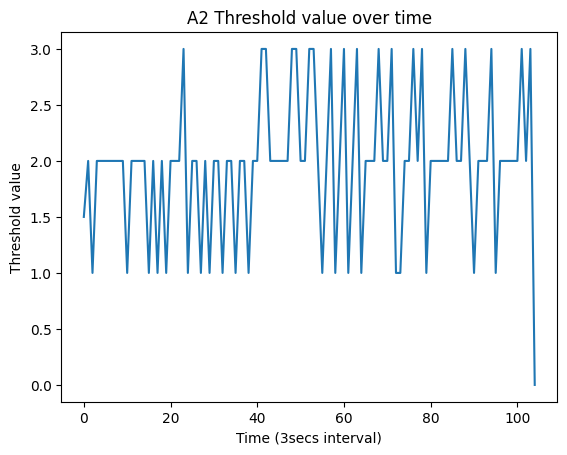

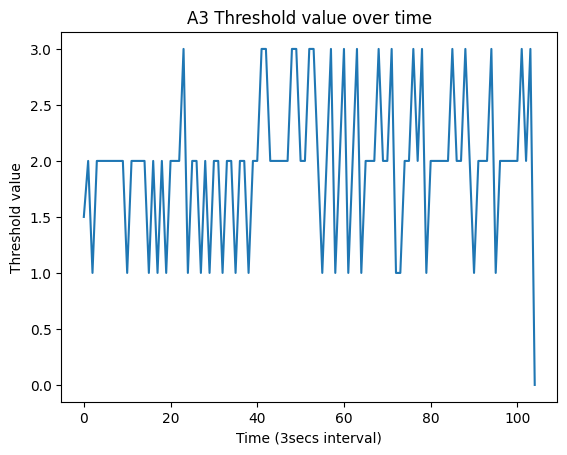

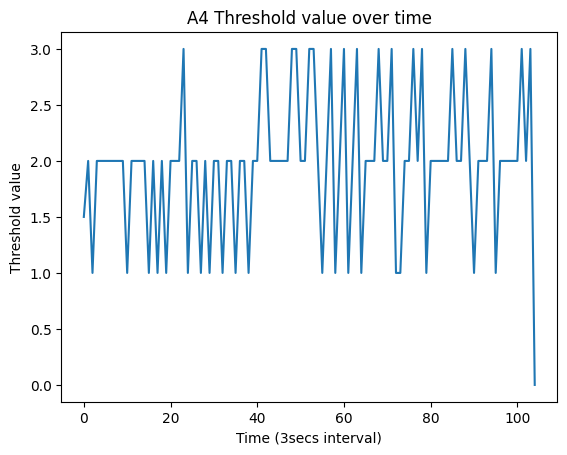

In [9]:
beta1y = list()
beta2y = list()
beta3y = list()
beta4y = list()

for betaXY in Threshold_all[0]:
    beta1y.append(betaXY[1])

for betaXY in Threshold_all[1]:
    beta2y.append(betaXY[1])

for betaXY in Threshold_all[2]:
    beta3y.append(betaXY[1])

for betaXY in Threshold_all[3]:
    beta4y.append(betaXY[1])

plt.plot(beta1y)
#plt.plot(A1_all.iloc[:, 0].to_list())
plt.title("A1 Threshold value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Threshold value")
plt.show()

plt.plot(beta2y)
#plt.plot(A2_all.iloc[:, 0].to_list())
plt.title("A2 Threshold value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Threshold value")
plt.show()

plt.plot(beta3y)
#plt.plot(A3_all.iloc[:, 0].to_list())
plt.title("A3 Threshold value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Threshold value")
plt.show()

plt.plot(beta4y)
#plt.plot(A4_all.iloc[:, 0].to_list())
plt.title("A4 Threshold value over time")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Threshold value")
plt.show()

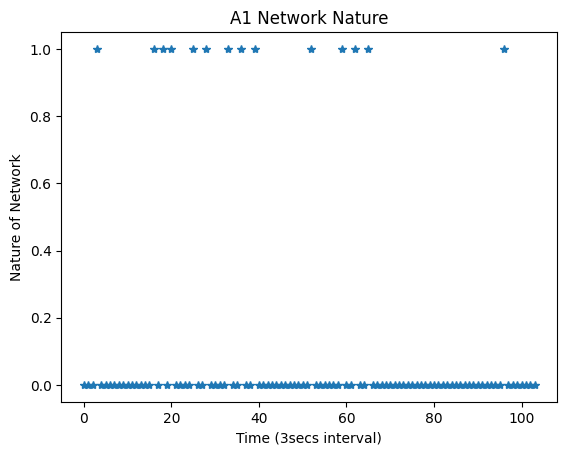

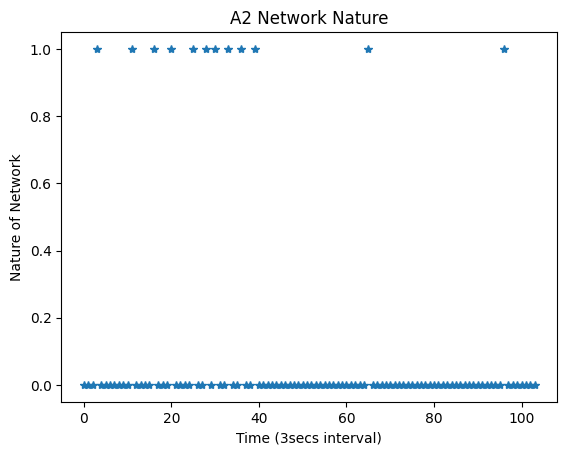

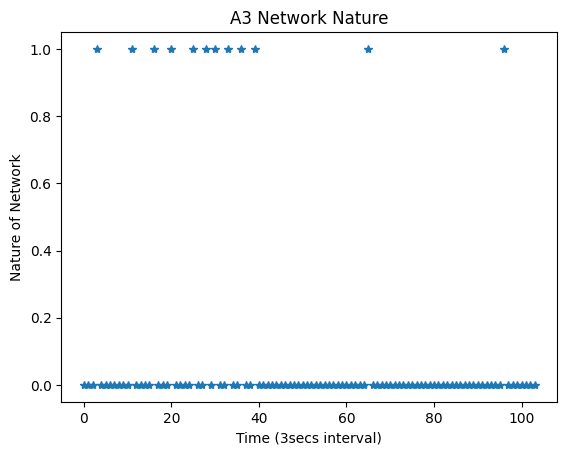

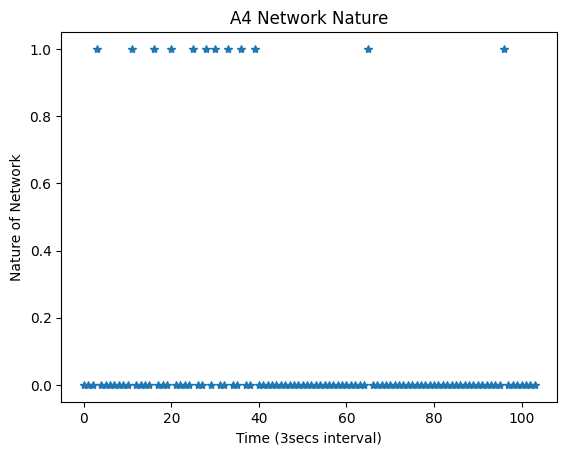

KeyboardInterrupt: 

In [15]:
beta1y = list()
beta2y = list()
beta3y = list()
beta4y = list()

for betaXY in N_all[0]:
    beta1y.append(betaXY[1])

for betaXY in N_all[1]:
    beta2y.append(betaXY[1])

for betaXY in N_all[2]:
    beta3y.append(betaXY[1])

for betaXY in N_all[3]:
    beta4y.append(betaXY[1])

plt.plot(beta1y, '*')
#plt.plot(A1_all.iloc[:, 0].to_list())
plt.title("A1 Network Nature")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Nature of Network")
plt.show()

plt.plot(beta2y, '*')
#plt.plot(A2_all.iloc[:, 0].to_list())
plt.title("A2 Network Nature")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Nature of Network")
plt.show()

plt.plot(beta3y, '*')
#plt.plot(A3_all.iloc[:, 0].to_list())
plt.title("A3 Network Nature")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Nature of Network")
plt.show()

plt.plot(beta4y, '*')
#plt.plot(A4_all.iloc[:, 0].to_list())
plt.title("A4 Network Nature")
plt.xlabel("Time (3secs interval)")
plt.ylabel("Nature of Network")
plt.show()


for idx in j_to_end:
    if N_all[0][idx][1] is True and N_all[1][idx][1] is True and N_all[2][idx][1] is True and N_all[3][idx][1] is True:
        timestamp = int(str(data_to_be_used[idx]['key'])[:-3])
        positive_traffic = get_netflow_data_at_nearest_time(timestamp)

        print(
            positive_traffic['source_ipv4_address'],
            positive_traffic['destination_ipv4_address'],
            positive_traffic['destination_transport_port'],
            getprotobynumber(positive_traffic['protocol_identifier']),
            data_to_be_used[idx]['key']
        )